# Cross-prediction between Countries

In [1]:
import os
os.chdir('R:\\JoePriceResearch\\RA_work_folders\\Isaac_Riley')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split as tts
pd.set_option('precision',3)
import numpy as np
import pandas as pd
import re as re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

The data's already pretty clean, so I'll just make sure there are no missing values.

In [3]:
df = pd.read_csv('clean.csv').fillna(0)

In [4]:
df.shape

(19893, 1509)

The shape looks good. We will want to weed out the factors we don't want the models to learn on. Start with the duplicates.

In [ ]:
df = df.drop_duplicates()

We'll also get rid a few HIV variables that we don't need.

In [6]:
cols0 = list(df.columns.values)
hiv = [c for c in cols0 if 'HIV' in c or 'hiv' in c]
print(hiv)

['PFHIV', 'SLESHIV1', 'SSPECHIV', 'SLESHIV2', 'XRESHIVP', 'XRESHIVB', 'YRESHIVP', 'YRESHIVB', 'zphclsbt_A person living with HIV giving a talk']


In [7]:
df = df.drop(hiv, axis = 1)
cols = df.columns.values

We also need to get rid of the district indicators, since we don't want those in the model.

In [11]:
dists = [c for c in cols if 'DISTRICT' in c]
df = df.drop(dists, axis=1)

Let's also divide the data up by level, just in case we need it later.

In [24]:
Plist = [c for c in cols if c[0]=='P' or c[:2] in ['zp', 'ZP']]
Slist = [c for c in cols if c[0]=='S' or c[:2]=='zs' or c in ['enr6', 'difenr', 'difenr2', 'numstu', 'xnumstu']]
Tlist = [c for c in cols if c[0] in ['T', 'X', 'Y'] or c[:2] in ['zx', 'zy', 'zt']]
IDlist = list(cols[:8])+([c for c in cols if 'REGION' in c or 'stratum' in c or 'COUNTRY' in c or 'DISTRICT' in c or c in ['strsize', 'PFCLASS', 'SFCLASS', 'zstype']])
IDlist = [i for i in IDlist if i not in dists]
combined = Plist+Slist+Tlist+IDlist
other = [c for c in cols if c not in combined and c not in dists and 'REGION' not in c]

In [25]:
print(len(Plist))
print(len(Slist))
print(len(Tlist))
print(len(IDlist))
print(len(combined))
print(len(other))

584
355
275
95
1309
27


In [26]:
print(other)

['prob1', 'RF1', 'pweight1', 'RF2', 'pweight2', 'achieved', 'pweighta', 'yclass', 'yclsize', 'zralocp', 'zmalocp', 'zraloct', 'zmaloct', 'ZHAMINP', 'ZHADESP', 'ZHAMINRT', 'ZHADESRT', 'ZHAMINMT', 'ZHADESMT', 'ZHAMINHT', 'ZHADESHT', 'ZRALEVP', 'ZMALEVP', 'ZRALEVT', 'ZMALEVT', 'sresloc', 'ZSRESLEV']


We also need to look at the variables that don't seem to fit into any other category.

In [27]:
df[other[:10]].describe()

prob1        RF1   pweight1        RF2   pweight2   achieved  \
count  1.989e+04  19893.000  19893.000  19893.000  19893.000  19893.000   
mean   7.672e-02     55.068      0.991     57.119      0.993   3834.389   
std    8.603e-02     66.669      0.330     78.216      0.415    547.732   
min    7.800e-04      1.000      0.083      1.000      0.045   2781.000   
25%    1.200e-02      8.300      0.790      7.900      0.720   3524.000   
50%    6.900e-02     14.000      1.000     13.000      0.980   3868.000   
75%    1.200e-01     84.000      1.200     84.000      1.200   4240.000   
max    1.000e+00   1275.000      8.300    606.000      3.600   4436.000   

        pweighta     yclass    yclsize    zralocp  
count  19893.000  19893.000  19893.000  19893.000  
mean       0.106      1.591     42.479    512.848  
std        0.046      1.045     21.199    103.742  
min        0.004      0.000      0.000      0.000  
25%        0.075      1.000     29.000    437.000  
50%        0.110      1.000     37.000    490.000  
75%        0.130      2.000     51.000    578.000  
max        0.320     13.000    200.000    966.000

In [28]:
df[other[10:20]].describe()

zmalocp    zraloct    zmaloct    ZHAMINP    ZHADESP   ZHAMINRT  \
count  19893.000  19893.000  19893.000  19893.000  19893.000  19893.000   
mean     525.574    593.306    623.494      0.304      0.060      0.963   
std      108.621    311.284    340.432      0.460      0.238      0.189   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%      454.000    646.000    643.000      0.000      0.000      1.000   
50%      509.000    728.000    749.000      0.000      0.000      1.000   
75%      573.000    782.000    833.000      1.000      0.000      1.000   
max     1090.000    959.000   1204.000      1.000      1.000      1.000   

        ZHADESRT   ZHAMINMT   ZHADESMT   ZHAMINHT  
count  19893.000  19893.000  19893.000  19893.000  
mean       0.798      0.953      0.794      0.958  
std        0.401      0.213      0.404      0.201  
min        0.000      0.000      0.000      0.000  
25%        1.000      1.000      1.000      1.000  
50%        1.000      1.000      1.000      1.000  
75%        1.000      1.000      1.000      1.000  
max        1.000      1.000      1.000      1.000

In [29]:
df[other[20:]].describe()

ZHADESHT    ZRALEVP    ZMALEVP    ZRALEVT    ZMALEVT    sresloc  \
count  19893.000  19893.000  19893.000  19893.000  19893.000  19893.000   
mean       0.803      4.370      3.531      6.127      5.565      0.024   
std        0.398      1.853      1.553      3.188      3.038      1.041   
min        0.000      0.000      0.000      0.000      0.000     -3.030   
25%        1.000      3.000      2.000      7.000      5.000     -0.720   
50%        1.000      4.000      3.000      8.000      7.000     -0.075   
75%        1.000      6.000      4.000      8.000      8.000      0.781   
max        1.000      8.000      8.000      8.000      8.000      2.800   

        ZSRESLEV  
count  19893.000  
mean       3.542  
std        1.087  
min        0.000  
25%        3.000  
50%        3.000  
75%        4.000  
max        6.000

In [30]:
print(Plist)

['PUPIL', 'PCLASS', 'PBDAY', 'PBMONTH', 'PBYEAR', 'PSEX', 'PNURSERY', 'PENGLISH', 'PMALIVE', 'PFALIVE', 'PBRO', 'PSIS', 'PSTAY1', 'PSTAY2', 'PSTAY3', 'PSTAY4', 'PSTAY5', 'PSTAY6', 'PSTAY7', 'PSTAY8', 'PSTAY9', 'PTRAVEL', 'PBOOKSHM', 'PTASK1', 'PTASK2', 'PTASK3', 'PTASK4', 'PTASK5', 'PTASK6', 'PTASK7', 'PTASK8', 'PTASK9', 'PTASK10', 'PTASK11', 'PTASK12', 'PTASK13', 'PTASK14', 'PPOS01', 'PPOS02', 'PPOS03', 'PPOS04', 'PPOS05', 'PPOS06', 'PPOS07', 'PPOS08', 'PPOS09', 'PPOS10', 'PPOS11', 'PPOS12', 'PPOS13', 'PPOS14', 'PPOS15', 'PPOS16', 'PPOS17', 'PPOS18', 'PPOS19', 'PPOS20', 'PPOS21', 'PPOS22', 'PPOS23', 'PPOS24', 'PPOS25', 'PPOS26', 'PPOS27', 'PPOS28', 'PPOS29', 'PPOS30', 'PPOS31', 'PMOTHER', 'PFATHER', 'PABSENT', 'PABWHY1', 'PABWHY2', 'PABWHY3', 'PABWHY4', 'PABWHY5', 'PABWHY6', 'PREPEAT', 'PREPEAT6', 'PRPTWHY1', 'PRPTWHY2', 'PRPTWHY3', 'PRPTWHY4', 'PBORROWC', 'PBORROWS', 'PBORROWO', 'PBORROW1', 'PBORROW2', 'PBORROW3', 'PMAT01', 'PMAT02', 'PMAT03', 'PMAT04', 'PMAT05', 'PMAT06', 'PMAT07', 

In [31]:
print(Slist)

['SCHOOL', 'enr6', 'difenr', 'difenr2', 'numstu', 'xnumstu', 'SSEX', 'SAGE', 'SQACADEM', 'SQTT', 'SEXPTCH', 'SEXPALL', 'SQSPEC', 'SQSPECDY', 'SQHLTH', 'SQHLTHDY', 'SPERIODS', 'SMINUTES', 'SACTHD01', 'SACTHD02', 'SACTHD03', 'SACTHD04', 'SACTHD05', 'SACTHD06', 'SPUPPR01', 'SPUPPR02', 'SPUPPR03', 'SPUPPR04', 'SPUPPR05', 'SPUPPR06', 'SPUPPR07', 'SPUPPR08', 'SPUPPR09', 'SPUPPR10', 'SPUPPR11', 'SPUPPR12', 'SPUPPR13', 'SPUPPR14', 'SPUPPR15', 'SPUPPR16', 'SPUPPR17', 'SPUPPR18', 'STCHPR01', 'STCHPR02', 'STCHPR03', 'STCHPR04', 'STCHPR05', 'STCHPR06', 'STCHPR07', 'STCHPR08', 'STCHPR09', 'STCHPR10', 'SMSURE01', 'SMSURE02', 'SMSURE03', 'SMSURE04', 'SMSURE05', 'SMSURE06', 'SMSURE07', 'SMSURE08', 'SMSURE09', 'SMSURE10', 'SMSURE11', 'SCONDIT', 'SRES01', 'SRES02', 'SRES03', 'SRES04', 'SRES05', 'SRES06', 'SRES07', 'SRES08', 'SRES09', 'SRES10', 'SRES11', 'SRES12', 'SRES13', 'SRES14', 'SRES15', 'SRES16', 'SRES17', 'SRES18', 'SRES19', 'SRES20', 'SRES21', 'SRES22', 'SRES23', 'SRES24', 'SRES25', 'SRES26', 'S

In [32]:
print(Tlist)

['XSEX', 'XAGE', 'XQACADEM', 'XQPROFES', 'XNUMYRS', 'XINSERVC', 'XINSERVD', 'XINSERVE', 'XBORROW', 'XBOOKCLS', 'XRESCKBD', 'XRESCHLK', 'XRESDSTR', 'XRESWCHT', 'XRESCPBD', 'XRESBKSH', 'XRESCLIB', 'XRESTTAB', 'XRESTCHR', 'XSITCLAS', 'XWRITCLS', 'XRESMAP', 'XRESENGD', 'XRESCGEO', 'XRESTGR', 'XRESTGM', 'XRESTGH', 'XRESBOOK', 'XRESRAD', 'XRESTV', 'XRESCAS', 'XRESCD', 'XRESVCR', 'XRESDVD', 'XRESCOMP', 'XRESINT', 'XRESPCPY', 'XNPERIOD', 'XMINPER', 'XHRSPREP', 'XMEETPAR', 'XTEACHMA', 'XTEACHSC', 'XTEACHSS', 'XTEACHHS', 'XTRAINRD', 'XTRAINMA', 'XTRAINSC', 'XTRAINSS', 'XTRAINHS', 'XABSNT1', 'XABSNT2', 'XABSNT3', 'XABSNT4', 'XABSNT5', 'XABSNT6', 'XABSNT7', 'XABSNT8', 'XABSNT9', 'XABSNT10', 'XABSNT11', 'XABSNT12', 'XPRINADV', 'XRCENTRE', 'XRCUSE1', 'XRCUSE2', 'XRCUSE3', 'XRCUSE4', 'XRCUSE5', 'XRCUSE6', 'XCONDLIV', 'XRRPTCOM', 'XRPTMCOM', 'XRPTHCOM', 'XSIGNHM', 'XTEST', 'YSEX', 'YAGE', 'YQACADEM', 'YQPROFES', 'YNUMYRS', 'YINSERVC', 'YINSERVD', 'YINSERVE', 'YBORROW', 'YBOOKCLS', 'YRESCKBD', 'YRESCHL

Now we create the final set with only the factors we really care about and want the models to learn on.

In [34]:
relevant = Slist+Plist+Tlist+['COUNTRY', 'zmalocp', 'zralocp']
country = df['COUNTRY']
df_original = 1*df
df = df_original[relevant]

Save the IDs for future reference.

In [35]:
df_id = df_original[IDlist]

Same goes for the "other" category.

In [36]:
df_other = df_original[other]

In [37]:
print(relevant)
print([c for c in relevant if c in hiv])

['SCHOOL', 'enr6', 'difenr', 'difenr2', 'numstu', 'xnumstu', 'SSEX', 'SAGE', 'SQACADEM', 'SQTT', 'SEXPTCH', 'SEXPALL', 'SQSPEC', 'SQSPECDY', 'SQHLTH', 'SQHLTHDY', 'SPERIODS', 'SMINUTES', 'SACTHD01', 'SACTHD02', 'SACTHD03', 'SACTHD04', 'SACTHD05', 'SACTHD06', 'SPUPPR01', 'SPUPPR02', 'SPUPPR03', 'SPUPPR04', 'SPUPPR05', 'SPUPPR06', 'SPUPPR07', 'SPUPPR08', 'SPUPPR09', 'SPUPPR10', 'SPUPPR11', 'SPUPPR12', 'SPUPPR13', 'SPUPPR14', 'SPUPPR15', 'SPUPPR16', 'SPUPPR17', 'SPUPPR18', 'STCHPR01', 'STCHPR02', 'STCHPR03', 'STCHPR04', 'STCHPR05', 'STCHPR06', 'STCHPR07', 'STCHPR08', 'STCHPR09', 'STCHPR10', 'SMSURE01', 'SMSURE02', 'SMSURE03', 'SMSURE04', 'SMSURE05', 'SMSURE06', 'SMSURE07', 'SMSURE08', 'SMSURE09', 'SMSURE10', 'SMSURE11', 'SCONDIT', 'SRES01', 'SRES02', 'SRES03', 'SRES04', 'SRES05', 'SRES06', 'SRES07', 'SRES08', 'SRES09', 'SRES10', 'SRES11', 'SRES12', 'SRES13', 'SRES14', 'SRES15', 'SRES16', 'SRES17', 'SRES18', 'SRES19', 'SRES20', 'SRES21', 'SRES22', 'SRES23', 'SRES24', 'SRES25', 'SRES26', 'S

And let's check on the df shape again, then replace infinite values, and look at its info.

In [645]:
df.shape

(19893, 1217)

In [646]:
df.replace(np.inf, 0)

SCHOOL  enr6  difenr  difenr2  numstu  xnumstu  SSEX  SAGE  SQACADEM  \
0          85    15       5        5      15       15     0    50         2   
1          85    15       5        5      15       15     0    50         2   
2          85    15       5        5      15       15     0    50         2   
3          85    15       5        5      15       15     0    50         2   
4          85    15       5        5      15       15     0    50         2   
5          85    15       5        5      15       15     0    50         2   
6          85    15       5        5      15       15     0    50         2   
7          85    15       5        5      15       15     0    50         2   
8          85    15       5        5      15       15     0    50         2   
9          85    15       5        5      15       15     0    50         2   
10         85    15       5        5      15       15     0    50         2   
11         85    15       5        5      15       15     0    50         2   
12         85    15       5        5      15       15     0    50         2   
13         85    15       5        5      15       15     0    50         2   
14         85    15       5        5      15       15     0    50         2   
15         98    53       2        2      24       24     0    45         2   
16         98    53       2        2      24       24     0    45         2   
17         98    53       2        2      24       24     0    45         2   
18         98    53       2        2      24       24     0    45         2   
19         98    53       2        2      24       24     0    45         2   
20         98    53       2        2      24       24     0    45         2   
21         98    53       2        2      24       24     0    45         2   
22         98    53       2        2      24       24     0    45         2   
23         98    53       2        2      24       24     0    45         2   
24         98    53       2        2      24       24     0    45         2   
25         98    53       2        2      24       24     0    45         2   
26         98    53       2        2      24       24     0    45         2   
27         98    53       2        2      24       24     0    45         2   
28         98    53       2        2      24       24     0    45         2   
29         98    53       2        2      24       24     0    45         2   
...       ...   ...     ...      ...     ...      ...   ...   ...       ...   
19863   40136   194      19      -19      14       14     1    35         3   
19864   40136   194      19      -19      14       14     1    35         3   
19865   40136   194      19      -19      14       14     1    35         3   
19866   40136   194      19      -19      14       14     1    35         3   
19867   40189   440      33      -33      20       20     1    49         3   
19868   40189   440      33      -33      20       20     1    49         3   
19869   40189   440      33      -33      20       20     1    49         3   
19870   40189   440      33      -33      20       20     1    49         3   
19871   40189   440      33      -33      20       20     1    49         3   
19872   40189   440      33      -33      20       20     1    49         3   
19873   40189   440      33      -33      20       20     1    49         3   
19874   40189   440      33      -33      20       20     1    49         3   
19875   40189   440      33      -33      20       20     1    49         3   
19876   40189   440      33      -33      20       20     1    49         3   
19877   40189   440      33      -33      20       20     1    49         3   
19878   40189   440      33      -33      20       20     1    49         3   
19879   40189   440      33      -33      20       20     1    49         3   
19880   40189   440      33      -33      20       20     1    49         3   
19881   40189   440      33      -33      20       20    

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19893 entries, 0 to 19892
Columns: 1217 entries, SCHOOL to zralocp
dtypes: float64(717), int64(496), object(4)
memory usage: 184.9+ MB


Now we can start the learning.

In [47]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

We'll need to create a data subset for each country, or at least that is the easiest way to do it when the datasets are a manageable size like this.

In [53]:
kenya = df[df['COUNTRY']=='KEN'].drop('COUNTRY', axis=1)
botswana = df[df['COUNTRY']=='BOT'].drop('COUNTRY', axis=1)
lesotho = df[df['COUNTRY']=='LES'].drop('COUNTRY', axis=1)
malawi = df[df['COUNTRY']=='MAL'].drop('COUNTRY', axis=1)
mauritius = df[df['COUNTRY']=='MAU'].drop('COUNTRY', axis=1)
mozambique = df[df['COUNTRY']=='MOZ'].drop('COUNTRY', axis=1)

Let's just be sure that went well.

In [54]:
print(kenya.shape)
print(botswana.shape)
print(lesotho.shape)
print(malawi.shape)
print(mauritius.shape)
print(mozambique.shape)

(4436, 1213)
(3868, 1213)
(4240, 1213)
(2781, 1213)
(3524, 1213)
(1044, 1213)


We'll also need a data frame for the MSE values to graph later.

In [57]:
df2 = pd.DataFrame({'Kenya': np.zeros(6),
                    'Botswana': np.zeros(6),
                    'Lesotho': np.zeros(6),
                    'Malawi': np.zeros(6),
                    'Mauritius': np.zeros(6),
                    'Mozambique': np.zeros(6)})

It looks good.

In [59]:
df2

Botswana  Kenya  Lesotho  Malawi  Mauritius  Mozambique
0       0.0    0.0      0.0     0.0        0.0         0.0
1       0.0    0.0      0.0     0.0        0.0         0.0
2       0.0    0.0      0.0     0.0        0.0         0.0
3       0.0    0.0      0.0     0.0        0.0         0.0
4       0.0    0.0      0.0     0.0        0.0         0.0
5       0.0    0.0      0.0     0.0        0.0         0.0

We also need to create a dictionary for some of the loops below.

In [60]:
df2dict = {'Botswana':0, 'Kenya':1, 'Lesotho':2, 'Malawi':3, 'Mauritius':4, 'Mozambique':5}

Let's see what one of the country frames looks like:

In [61]:
kenya['STYPE'].describe()

count    4436.000
mean        0.101
std         0.302
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         1.000
Name: STYPE, dtype: float64

Now to make predictions on school type from a model trained on Kenya:

First, we just try the process manually to make sure it works.

In [684]:
model = LogisticRegression()
#model = RandomForestClassifier()
train = kenya
test = botswana
target = 'STYPE'

In [685]:
X_tr = train.drop(target, axis=1)
X_tr.shape

(4436, 1212)

In [686]:
X_te = test.drop(target, axis=1)
X_te.shape

(3868, 1212)

In [687]:
y_tr = train[target]
y_tr.shape

(4436,)

In [688]:
y_te = test[target]
y_te.shape

(3868,)

In [689]:
model.fit(X_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [690]:
preds = model.predict(X_te)

In [691]:
accuracy_score(y_te, preds)

0.09488107549120993

Looks like everything went well. Let's speed everything up with loops, and use MSE instead of accuracy and SVR instead of LR, but the same general idea. We will be predicting school type first (private=1, public=0).

In [56]:
def pcorrect(model, train, test, target):
    X_tr = train.drop(target, axis=1)
    X_te = test.drop(target, axis=1)
    y_tr = train[target]
    y_te = test[target]
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    return mean_squared_error(y_te, preds)

First we need another dictionary to make things easier.

In [62]:
countries = [kenya,botswana,lesotho,malawi,mauritius,mozambique]
cdict = dict(zip(df2.columns.values,countries))
print(cdict)

{'Botswana':          SCHOOL  enr6  difenr  difenr2  numstu  xnumstu  SSEX  SAGE  SQACADEM  \
3868     101354    24      21       21      23       23     1    55         4   
3869     101354    24      21       21      23       23     1    55         4   
3870     101354    24      21       21      23       23     1    55         4   
3871     101354    24      21       21      23       23     1    55         4   
3872     101354    24      21       21      23       23     1    55         4   
3873     101354    24      21       21      23       23     1    55         4   
3874     101354    24      21       21      23       23     1    55         4   
3875     101354    24      21       21      23       23     1    55         4   
3876     101354    24      21       21      23       23     1    55         4   
3877     101354    24      21       21      23       23     1    55         4   
3878     101354    24      21       21      23       23     1    55         4   
3879     101354

In [ ]:
df2cols = df2.columns.values 
for c in df2cols:
    for d in range(6):
        if c != df2cols[d]:
            #print(c, df2cols[d])
            df2[c][d] = pcorrect(SVR(), cdict[c], cdict[df2cols[d]], 'STYPE')

In [724]:
df2

Botswana  Kenya  Lesotho  Malawi  Mauritius  Mozambique
0     0.000  0.097    0.513   0.150      0.123       0.091
1     0.093  0.000    0.516   0.148      0.120       0.086
2     0.551  0.558    0.000   0.371      0.436       0.642
3     0.228  0.230    0.410   0.000      0.213       0.250
4     0.177  0.177    0.450   0.189      0.000       0.187
5     0.043  0.041    0.555   0.124      0.086       0.000

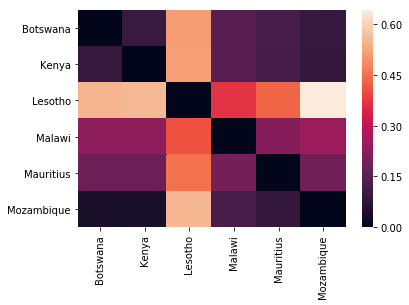

In [729]:
import seaborn as sns
%matplotlib inline

Index= ['Botswana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Mozambique']
Cols = ['Botswana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Mozambique']
sns.heatmap(df2, yticklabels=Index)

This looks good. It's just what we were hoping to get, a clean visual of the main idea. Let's do the same for math and reading score, except that we won't make the model run each time before predicting, but rather creating the model and then making the predictions on all 5 other countries.

In [74]:
df3 = df2*1
df2cols = df2.columns.values 

In [64]:
def pcorrect2(model, train, testlist, target):
    X_tr = train.drop(target, axis=1)
    y_tr = train[target]
    #print(y_tr.dtype)
    #print(y_te.dtype)
    model.fit(X_tr, y_tr)
    mselist = []
    for t in testlist:
        X_te = t.drop(target, axis=1)
        y_te = t[target]
        preds = model.predict(X_te)
        mse = mean_squared_error(y_te, preds)
        print(mse)
        mselist.append(mse)
    return mselist

We'll need to make an intermediate matrix using the lists generated, and then create a df with 0s on the main diagonal.

In [739]:
outmatrix = []
for c in cdict.keys():
    #for d in range(6):
    print(c)
    outlist = pcorrect2(SVR(), cdict[c], countries, 'STYPE')
    outmatrix.append(outlist)

Botswana
Kenya
Lesotho
Malawi
Mauritius
Mozambique


In [741]:
print(outmatrix)

[[0.010005680671793221, 0.09329475814107567, 0.5514396441146575, 0.22845157683763223, 0.17669138354653274, 0.043149184982077655], [0.09654722236583496, 0.009999075606249647, 0.5579316719648871, 0.22976407909608065, 0.1771738450915673, 0.041490127055886436], [0.5125014751922421, 0.5156755504939391, 0.010007075855229482, 0.4095548377882706, 0.4501952483484415, 0.5550482141448534], [0.1504372549403889, 0.14847392799653225, 0.37097926954080734, 0.010000909948630567, 0.18897682388731213, 0.12411993382509087], [0.12310230454867965, 0.12032025995906667, 0.43561149738652927, 0.21333398098541848, 0.009999280527859008, 0.08581052232615215], [0.09111205377888601, 0.0862082643549952, 0.6419584637999678, 0.25015951917985113, 0.18737209401038724, 0.009996637762615558]]


In [756]:
for i in range(6):
    for j in range(5):
        if i > j:    
            print(i,j)

1 0
2 0
2 1
3 0
3 1
3 2
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3
5 4


This was just a test of the coordinate reassignment algorithm. After a lot of whiteboard work and some trial and error, it seems to be doing what it is supposed to. Now we can put it to the real test.

In [759]:
for i in range(6):
    for j in range(5):
        if i > j:    
            df3[df3cols[j]][i] = outmatrix[i][j]
        if i <= j:
            df3[df3cols[j+1]][i] = outmatrix[i][j]

In [760]:
df3

Botswana  Kenya  Lesotho  Malawi  Mauritius  Mozambique
0     0.000  0.010    0.093   0.551      0.228       0.177
1     0.097  0.000    0.010   0.558      0.230       0.177
2     0.513  0.516    0.000   0.010      0.410       0.450
3     0.150  0.148    0.371   0.000      0.010       0.189
4     0.123  0.120    0.436   0.213      0.000       0.010
5     0.091  0.086    0.642   0.250      0.187       0.000

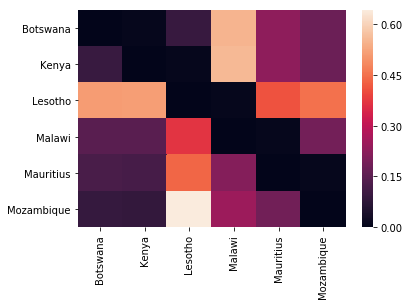

In [761]:
import seaborn as sns
%matplotlib inline

Index= ['Botswana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Mozambique']
Cols = ['Botswana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Mozambique']
sns.heatmap(df3, yticklabels=Index)

In [2]:
def pcorrect(model, train, test, target):
    X_tr = train.drop(target, axis=1)
    y_tr = train[target]#.astype(int)
    X_te = test.drop(target, axis=1)
    y_te = test[target]#.astype(int)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    return accuracy_score(y_test, preds)

In [762]:
outmatrix2 = []
for c in cdict.keys():
    #for d in range(6):
    print(c)
    outlist = pcorrect2(SVR(), cdict[c], countries, 'zmalocp')
    outmatrix2.append(outlist)

Botswana
Kenya
Lesotho
Malawi
Mauritius
Mozambique


In [764]:
df4 = df3*1

In [765]:
for i in range(6):
    for j in range(5):
        if i > j:    
            df4[df3cols[j]][i] = outmatrix2[i][j]
        if i <= j:
            df4[df3cols[j+1]][i] = outmatrix2[i][j]

In [766]:
df4

Botswana      Kenya    Lesotho     Malawi  Mauritius  Mozambique
0      0.000   8891.259   7407.685   9892.547  14508.614   24021.782
1  10558.382      0.000   6503.269   6530.314   9604.859   28637.554
2  17484.184   9282.254      0.000   4312.798   4637.375   41271.130
3  23831.273  13188.959   5592.217      0.000   4090.042   50880.056
4  11081.039  14484.485  22586.016  30556.231      0.000   19132.622
5  13621.305   7393.412   4730.458   6272.365  34769.737       0.000

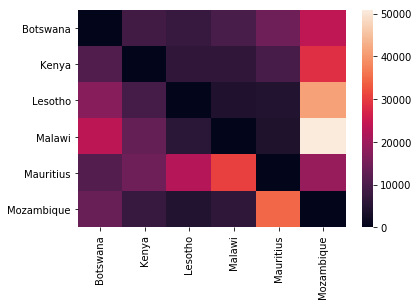

In [767]:
import seaborn as sns
%matplotlib inline

Index= ['Botswana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Mozambique']
Cols = ['Botswana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Mozambique']
sns.heatmap(df4, yticklabels=Index)

In [68]:
outmatrix3 = []
for c in cdict.keys():
    #for d in range(6):
    print(c)
    outlist = pcorrect2(SVR(), cdict[c], countries, 'zralocp')
    outmatrix3.append(outlist)

Botswana
9950.193789418263
9800.259433649193
10427.621013812195
14542.954330214061
15291.34109737801
8978.532637637769
Kenya
10305.3963013266
9630.35948572487
9194.131166094005
12735.631442577842
15871.234153962545
7957.12251348977
Lesotho
18621.407791940914
16260.871361862102
4717.904177420318
3267.323061032702
27599.437827883343
5467.072385518919
Malawi
24555.97681095598
21527.268486586836
6156.136790601584
2678.805770322356
34770.81929244448
7484.783625364908
Mauritius
10509.933479718387
10875.0452140626
15471.752006792773
21451.81994167357
14242.219912401828
13333.48685809358
Mozambique
15599.647186440898
13673.023196658352
4786.101509824701
4431.7773820182465
23774.488236103556
4880.167683706691


In [70]:
df5 = df2*1

This next function contains a tricky little algorithm that takes an nxn data frame and outputs and (n+1)x(n+1) data frame with zeroes on the main diagonal.

In [75]:
for i in range(6):
    for j in range(5):
        if i > j:    
            df5[df2cols[j]][i] = outmatrix3[i][j]
        if i <= j:
            df5[df2cols[j+1]][i] = outmatrix3[i][j]

In [76]:
df5

Botswana      Kenya    Lesotho     Malawi  Mauritius  Mozambique
0      0.000   9950.194   9800.259  10427.621  14542.954   15291.341
1  10305.396      0.000   9630.359   9194.131  12735.631   15871.234
2  18621.408  16260.871      0.000   4717.904   3267.323   27599.438
3  24555.977  21527.268   6156.137      0.000   2678.806   34770.819
4  10509.933  10875.045  15471.752  21451.820      0.000   14242.220
5  15599.647  13673.023   4786.102   4431.777  23774.488       0.000

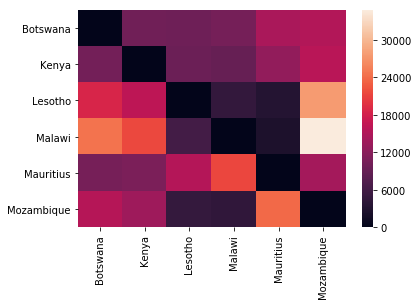

In [77]:
import seaborn as sns
%matplotlib inline

Index= ['Botswana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Mozambique']
Cols = ['Botswana', 'Kenya', 'Lesotho', 'Malawi', 'Mauritius', 'Mozambique']
sns.heatmap(df5, yticklabels=Index)

This is good so far. But it's probably worth going back and running within-country predictions just to make sure our assumption of high within-country accuracy isn't too far off.

In [79]:
def pcorrect3(model, data, target):
    numtr = round(data.shape[0]*0.8)
    X_tr = data.drop(target, axis=1)[:numtr]
    X_te = data.drop(target, axis=1)[:numtr]
    y_tr = data[target][:numtr]
    #print(y_tr.dtype)
    y_te = data[target][:numtr]
    #print(y_te.dtype)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    return mean_squared_error(y_te, preds)

4436

Let's test on Kenya again.

In [92]:
df2['Kenya'][1] = pcorrect3(SVR(), kenya, 'STYPE')

0.009992999509362723

And next on Botswana.

In [93]:
pcorrect3(SVR(), botswana, 'STYPE')

0.00999935383770068

That is small, very small, as assumed. Let's go ahead and fix up df2 with the other values, just for the exercise.

In [99]:
df2['Lesotho'][2] = pcorrect3(SVR(), lesotho, 'STYPE')

In [100]:
df2['Malawi'][2] = pcorrect3(SVR(), malawi, 'STYPE')

In [ ]:
df2['Mauritius'][2] = pcorrect3(SVR(), mauritius, 'STYPE')

In [101]:
df2['Mozambique'][2] = pcorrect3(SVR(), mozambique, 'STYPE')

Looks like everything worked. For the figures, since the within-country predictions are so close to 0, we don't need to go back and re-graph it here; the difference wouldn't be visible.

Just one more thing - let's also try out a RF classifier, just because.

In [431]:
from sklearn import linear_model
clf = RandomForestClassifier()


In [433]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [435]:
preds = clf.predict(X_test)

In [436]:
preds


array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [440]:
accuracy_scre(y_test, preds)

0.8782316442605997

Interesting, but I think I like SVR. There is also a good paper we reference in the slides that details why it may be a better choice. Next we will go on to clustering and dimensionality reduction, especially t-SNE.